In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import plotting

2024-09-21 20:19:10.014707: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-21 20:19:10.025822: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-21 20:19:10.029011: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-21 20:19:10.037680: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-21 20:19:10.751342: W tensorflow/compiler/tf2

In [2]:
# force gpu use
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

I0000 00:00:1726939151.312910   19234 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726939151.337761   19234 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726939151.340539   19234 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [3]:
# quite good with @tf.fuinction
@tf.function
def custom_activation(x):
    return tf.sin(x)

In [4]:
def setup_model() -> tf.keras.models.Sequential:
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Input((2,)),
            tf.keras.layers.Dense(units=32, activation=custom_activation),
            tf.keras.layers.Dense(units=32, activation=custom_activation),
            tf.keras.layers.Dense(units=32, activation=custom_activation),
            tf.keras.layers.Dense(units=1),
        ]
    )

    model.summary()
    model.compile(optimizer="Adam", loss="mean_squared_error")
    return model, tf.keras.optimizers.Adam(learning_rate=0.001)

$\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}=f$

In [5]:
tf_pi = tf.constant(np.pi)


def real_u(x, y):
    return np.sin(np.pi * x) * np.sin(np.pi * y)

# TODO: experiment with tf function and parameters
@tf.function
def f(x, y):
    return -2 * tf_pi * tf_pi * tf.sin(tf_pi * y) * tf.sin(tf_pi * x)

I0000 00:00:1726939151.381157   19234 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726939151.383927   19234 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726939151.386377   19234 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726939151.497314   19234 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

### Params

In [6]:
grid_size = (50, 50)
plotting_grid_size = (200, 200)
x_limits = (0, 2)
y_limits = (0, 2)
border_grid_size = (50, 50)
koef = 10

In [7]:
def get_area(grid_size, border_grid_size, x_limits, y_limits):
    x = np.linspace(x_limits[0], x_limits[1], border_grid_size[0], dtype=np.float32)
    y = np.linspace(y_limits[0], y_limits[1], border_grid_size[1], dtype=np.float32)

    border = mesh_to_pairs(np.meshgrid(x, y)).reshape(border_grid_size[0], border_grid_size[1], 2)
    border_01 = np.append(border[0], border[0][..., [1, 0]])
    border_02 = np.append(border[-1], border[-1][..., [1, 0]])

    x = np.linspace(x_limits[0], x_limits[1], grid_size[0], dtype=np.float32)
    y = np.linspace(y_limits[0], y_limits[1], grid_size[1], dtype=np.float32)

    # FIXME: area inside points is in border??
    return mesh_to_pairs(np.meshgrid(x, y)),\
        np.append(border_01, border_02).reshape(border_grid_size[0] * 4, 2)

def mesh_to_pairs(meshgrid: list[np.ndarray]):
    return np.column_stack((meshgrid[0].flatten(), meshgrid[1].flatten()))

In [8]:
@tf.function
def ode_system(coord, border, net):
    # set type to avoid overcalculations
    # border = tf.constant(border, dtype=tf.float32)
    # coord = tf.constant(coord, dtype=tf.float32)
    with tf.GradientTape(watch_accessed_variables=False, persistent=True) as tape:
        tape.watch(coord)
        with tf.GradientTape(watch_accessed_variables=False, persistent=True) as tape1:
            tape1.watch(coord)
            u = net(coord)
        grad_u = tape1.gradient(u, coord)
        du_dx = grad_u[..., 0]
        du_dy = grad_u[..., 1]
        del tape1

    d2u_dx2 = tape.gradient(du_dx, coord)[..., 0]
    d2u_dy2 = tape.gradient(du_dy, coord)[..., 1]
    del tape
    
    x = coord[..., 0]
    y = coord[..., 1]
    ode_loss = d2u_dx2 + d2u_dy2 - f(x, y)
    IC_loss = net(border) - tf.zeros((len(border), 1))

    square_loss = tf.square(ode_loss) + koef * tf.square(IC_loss)
    total_loss = tf.reduce_mean(square_loss)

    return total_loss

In [9]:
# train model
@tf.function
def train_with_loss(train_coord, border, net, optm):
    for itr in tf.range(0, 6000):
        with tf.GradientTape() as tape:
            train_loss = ode_system(train_coord, border, net)
            # train_loss_record.append(train_loss)

        grad_w = tape.gradient(train_loss, net.trainable_variables)
        optm.apply_gradients(zip(grad_w, net.trainable_variables))
        del tape

        if itr % 500 == 0:
            # USE TF.PRINT()!!!
            tf.print("epoch:", itr, "loss:", train_loss)  #.numpy())
            if train_loss < 0.0001:
                break

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,241 (8.75 KB)

 Trainable params: 2,241 (8.75 KB)

 Non-trainable params: 0 (0.00 B)

epoch: 0 loss: 95.0692
epoch: 500 loss: 0.33759138
epoch: 1000 loss: 0.0582707301
epoch: 1500 loss: 0.0213387087
epoch: 2000 loss: 0.0127053047
epoch: 2500 loss: 0.00886525214
epoch: 3000 loss: 0.00681334967
epoch: 3500 loss: 0.00542252464
epoch: 4000 loss: 0.0045133573
epoch: 4500 loss: 0.00367772672
epoch: 5000 loss: 0.00326864771
epoch: 5500 loss: 0.00329088676


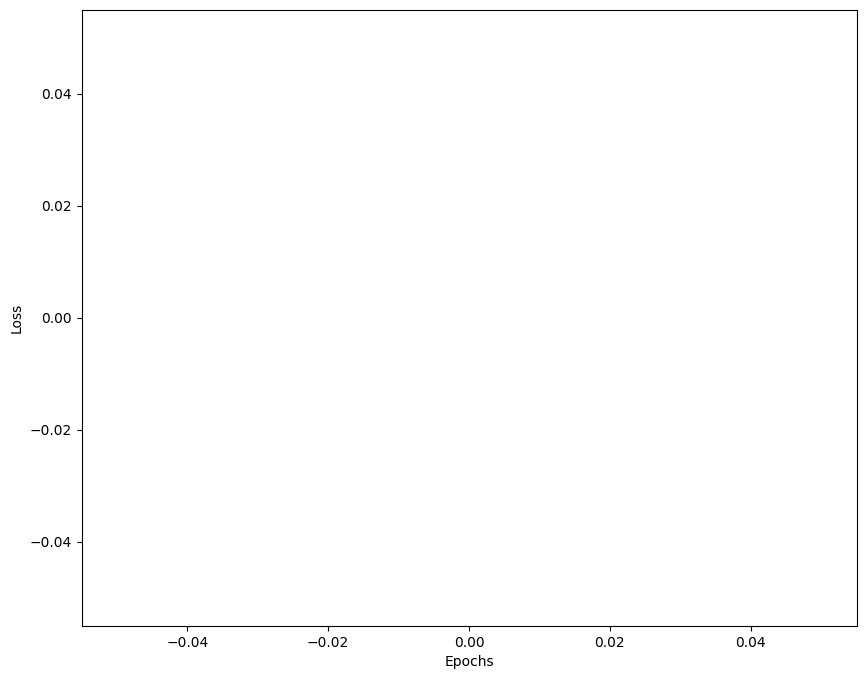

In [10]:
model, optm = setup_model()
train_loss_record = []
train_with_loss(*get_area(grid_size, border_grid_size, x_limits, y_limits),
                model, optm)
plotting.NNPlots.plotLoss(train_loss_record)

In [11]:
# NN.save("model.h5")
# NN = tf.keras.models.load_model("model.h5")

In [12]:
"""
Preparing usefull arrays for plotting and accuracy calculation
"""
x = np.linspace(x_limits[0], x_limits[1], plotting_grid_size[0])
y = np.linspace(y_limits[0], y_limits[1], plotting_grid_size[1])
x, y = np.meshgrid(x, y)
test_x = np.linspace(x_limits[0], x_limits[1], plotting_grid_size[0])
test_y = np.linspace(x_limits[0], x_limits[1], plotting_grid_size[1])
test_x, test_y = np.meshgrid(test_x, test_y)
train_u = real_u(x, y)
true_u = real_u(test_x, test_y)
test_coord = np.column_stack((test_x.flatten(), test_y.flatten()))
pred_coord = list()
for _x in x[0]:
    for _y in x[0]:
        pred_coord.append([_x, _y])
pred_u = model.predict(np.array(pred_coord)).ravel().reshape(plotting_grid_size[0], plotting_grid_size[1])

I0000 00:00:1726939170.723494   19290 service.cc:146] XLA service 0x7f61b40037e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726939170.723534   19290 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-09-21 20:19:30.733650: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 248/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step

I0000 00:00:1726939171.059854   19290 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 591us/step


/home/arnautov/projectPractice/pinn_puasson/src/plotting.py:74: UserWarning: The following kwargs were not used by contour: 'linestyle'
  real.contour(
/home/arnautov/projectPractice/pinn_puasson/src/plotting.py:95: UserWarning: The following kwargs were not used by contour: 'linestyle'
  pred.contour(


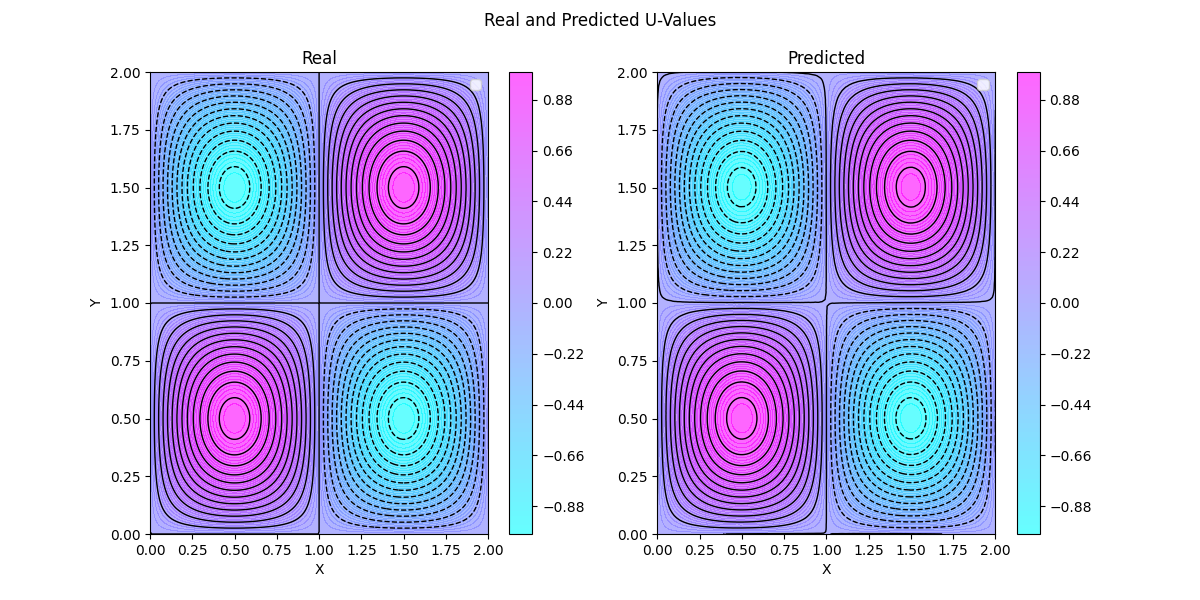

In [16]:
%matplotlib widget
plotter = plotting.NNPlots(test_x, test_y, true_u, x, y, pred_u, x_limits, y_limits)
# plotter.plot3d()
# plotter.plot2d_fix_x(3)
plotter.plot2d_contour(color_map="cool", contour_levels=30)

# Accuracy calculation

In [14]:
pred = np.array([i[0] for i in pred_u.reshape(np.prod(pred_u.shape), 1)])
true = np.array([i[0] for i in true_u.reshape(np.prod(true_u.shape), 1)])

In [15]:
from accuracy import AccuracyCalc

# calc = AccuracyCalc(model, real_u, )

# print("Accuracy:", good_perc(pred, true), maape(pred, true))